In [0]:
import tensorflow as tf
import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import random
from keras.utils import to_categorical

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train= x_train/255
x_test = x_test/255

In [0]:
# one_hot maker
def one_hot(vector):
    one_hot_vec = np.zeros([len(vector), int(max(vector[0:len(vector)])+1)])
    
    for i in range(len(one_hot_vec)):
        one_hot_vec[i, vector[i, 0]] = 1
       
    return one_hot_vec

In [0]:
# creating minibatches
def mini_batch(X, Y, size):
    idx = np.random.randint(np.size(Y[:, 0]), size = (size,1))
    x_bat = X[idx]
    x_bat = x_bat.reshape(size, 32, 32, 3)
    y_bat = Y[idx]
    y_bat = y_bat.reshape(size, 10)
    
    return x_bat, y_bat

In [0]:
tf.reset_default_graph()
# placeholders
x = tf.placeholder(tf.float32, [None,32,32,3])
y = tf.placeholder(tf.float32,[None, 10])

# weights

w1 = tf.get_variable('w1', [2,2,3,80], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.get_variable('b1', [80], initializer=tf.contrib.layers.xavier_initializer())
w2 = tf.get_variable('w2', [2,2,80,80], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.get_variable('b2', [80], initializer=tf.contrib.layers.xavier_initializer())

In [35]:
# CNN model
with tf.device("/gpu:0"):
    conv1 = tf.nn.conv2d(x, w1, strides = [1,1,1,1], padding = 'SAME')
    bias1 = tf.nn.bias_add(conv1, b1)
    h1 = tf.nn.relu(bias1)
    
    m1 = tf.nn.max_pool(h1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    drop_1 = tf.nn.dropout(m1, 0.8)
    
    conv2 = tf.nn.conv2d(drop_1, w2, strides = [1,1,1,1], padding = 'SAME')
    bias2 = tf.nn.bias_add(conv2, b2)
    h2 = tf.nn.relu(bias2)
    
    m2 = tf.nn.max_pool(h2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    drop_2 = tf.nn.dropout(m2, 0.8)
    
    flat_0 = tf.contrib.layers.flatten(drop_2)
    flat_1 = tf.layers.dense(flat_0, 256, activation='relu')
    classifier = tf.layers.dense(flat_1, 10, activation=tf.nn.softmax)
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=classifier, labels=y))
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    
    print('model summary')
    print('x      : ', x.shape)
    print('conv1  : ', drop_1.shape)
    print('conv2  : ', drop_2.shape)
    print('flat_0 : ', flat_0.shape)
    print('flat_1 : ', flat_1.shape)
    print('final  : ', classifier.shape)

model summary
x      :  (?, 32, 32, 3)
conv1  :  (?, 16, 16, 80)
conv2  :  (?, 8, 8, 80)
flat_0 :  (?, 5120)
flat_1 :  (?, 256)
final  :  (?, 10)


In [36]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

cost = []
# training
for epoch in range(999):
    x_batch, y_batch = mini_batch(x_train, to_categorical(y_train, num_classes=10), 600)
    training_step = sess.run(optimizer, {x: x_batch, y: y_batch})
    
    if epoch%200==0:
        print("Iteration: ", epoch)
    
    cost.append(sess.run(loss, {x: x_batch, y: y_batch}))

Iteration:  0
Iteration:  200
Iteration:  400
Iteration:  600
Iteration:  800


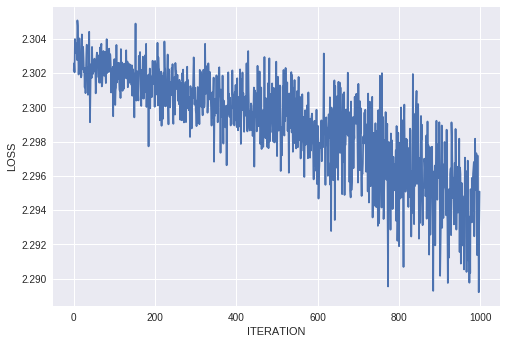

In [37]:
plt.plot(range(0, epoch+1), cost[:])
plt.xlabel("ITERATION")
plt.ylabel("LOSS")
plt.show()

In [38]:
randomness = range(1, 6000)
# test set evaluation
test_loss = sess.run(loss, {x: x_test[randomness], y: one_hot(y_test[randomness])})

print("loss on training set : ", cost[-1])
print("loss on test set     : ", test_loss)

# metrics
test_true= tf.equal(np.argmax(sess.run(classifier, {x: x_test[randomness]}), axis=1), np.argmax(y_test[randomness], axis=1))
test_accuracy = tf.reduce_mean(tf.cast(test_true, dtype="float"))

train_true = tf.equal(np.argmax(sess.run(classifier, {x: x_train[randomness]}), axis=1), np.argmax(y_train[randomness], axis=1))
train_accuracy = tf.reduce_mean(tf.cast(train_true, dtype="float"))

train_score = sess.run(train_accuracy)*100
test_score = sess.run(test_accuracy)*100

print("train accuracy : %.2f" %train_score, "%")
print("test accuracy  : %.2f" %test_score, "%")

loss on training set :  2.2950764
loss on test set     :  2.2940054
train accuracy : 91.00 %
test accuracy  : 91.10 %


## Things I've tried
1. Residual network
2. lots of learning rates
3. cnn with 4 to 7 layers
4. Average pooling
5. A **LOT** of neural network models

## What Worked

1. Switching from Adam optimizer to Gradient Descent optimizer
2. Using a wider network instead of a deeper one, since, the images are of smaller resolution which causes vanishing gradient problem
3. For Mini Batch SGD, the batch size should be somewhat bigger
4. messing around with the learning rate a **lot**

## Lessons learned
1. Always start with very simple and shallow model
2. **Always gather lots of data with high resolution images**
3. Early Stopping helps

## Helpful article
https://towardsdatascience.com/7-practical-deep-learning-tips-97a9f514100e